In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pathlib
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_dir = pathlib.Path( "/content/gdrive/MyDrive/Colab Notebooks/BD_Elephant/train")
test_dir = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/BD_Elephant/test")

In [ ]:
train_image_count = len(list(train_dir.glob('*/*')))
print(train_image_count)

840


In [ ]:
test_image_count = len(list(test_dir.glob('*/*')))
print(test_image_count)

188


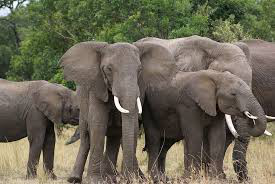

In [ ]:
african = list(train_dir.glob('African/*'))
PIL.Image.open(str(african[0]))

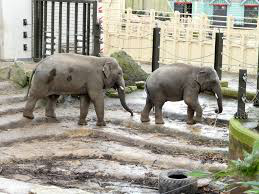

In [ ]:
asian = list(train_dir.glob('Asian/*'))
PIL.Image.open(str(asian[0]))

In [ ]:
batch_size = 32
img_height = 244
img_width = 244

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 840 files belonging to 2 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 188 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['African', 'Asian']


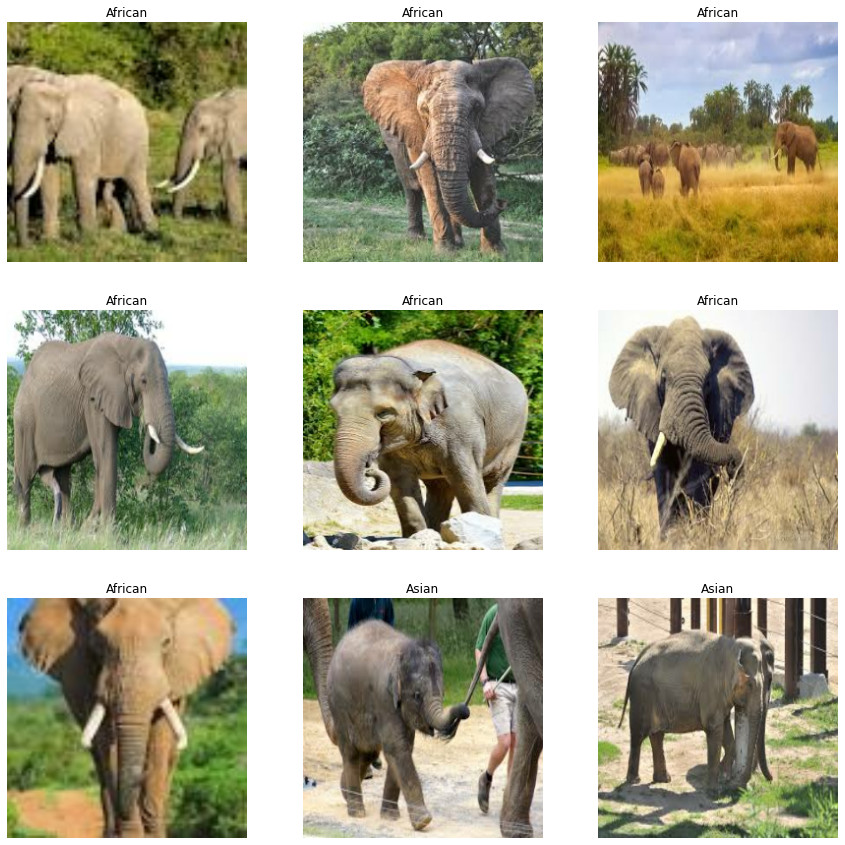

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 244, 244, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
import tensorflow_hub as hub

In [ ]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label


train_batches      = train_ds.map(format_image).prefetch(1)
test_batches       = test_ds.map(format_image).prefetch(1)

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [ ]:
feature_extractor.trainable = False

In [ ]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=test_batches)

Epoch 1/6
27/27 [==============================] - 172s 6s/step - loss: 0.7135 - accuracy: 0.5738 - val_loss: 0.4877 - val_accuracy: 0.7872
Epoch 2/6
27/27 [==============================] - 27s 974ms/step - loss: 0.5900 - accuracy: 0.6762 - val_loss: 0.3968 - val_accuracy: 0.8351
Epoch 3/6
27/27 [==============================] - 27s 977ms/step - loss: 0.5229 - accuracy: 0.7393 - val_loss: 0.3655 - val_accuracy: 0.8617
Epoch 4/6
27/27 [==============================] - 27s 976ms/step - loss: 0.4989 - accuracy: 0.7548 - val_loss: 0.3509 - val_accuracy: 0.8723
Epoch 5/6
27/27 [==============================] - 27s 970ms/step - loss: 0.4757 - accuracy: 0.7690 - val_loss: 0.3407 - val_accuracy: 0.8777
Epoch 6/6
27/27 [==============================] - 27s 970ms/step - loss: 0.4591 - accuracy: 0.7821 - val_loss: 0.3359 - val_accuracy: 0.8777


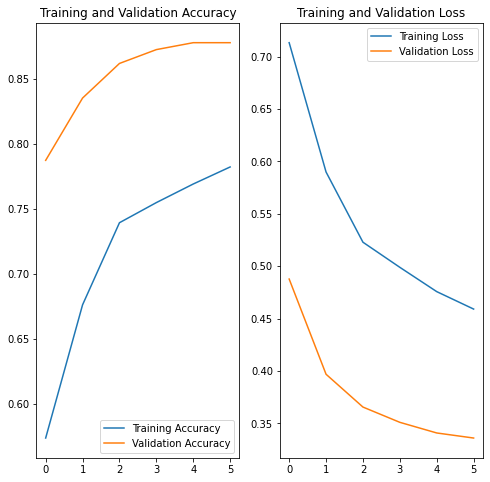

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
class_names

['African', 'Asian']

In [ ]:
class_names = np.array(class_names)
class_names

array(['African', 'Asian'], dtype='<U7')

In [ ]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['Asian', 'African', 'African', 'African', 'African', 'Asian',
       'Asian', 'Asian', 'Asian', 'Asian', 'Asian', 'African', 'African',
       'African', 'Asian', 'African', 'African', 'Asian', 'African',
       'African', 'Asian', 'Asian', 'Asian', 'African', 'African',
       'Asian', 'African', 'African', 'African', 'African', 'African',
       'African'], dtype='<U7')

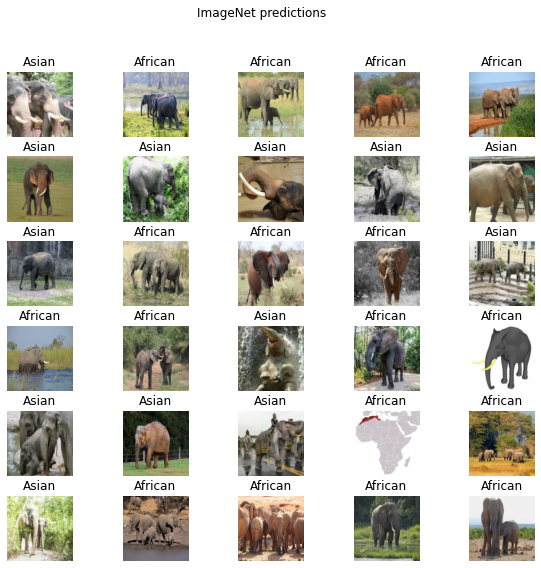

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")